## Part 1:
Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

In [2]:
ult = pd.read_json('logins.json')

In [3]:
ult.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
ult.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
ult.isnull().values.any()

False

In [6]:
ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
#adding column to allow for sum of values
ult['instance'] = 1

In [8]:
#grouping by 15 minute intervals
inter = ult.groupby(pd.Grouper(key='login_time', freq='15T'))['instance'].agg('sum')
inter.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, Name: instance, dtype: int64

In [9]:
type(inter)

pandas.core.series.Series

In [10]:
intervals = inter.to_frame()
intervals.head()

,instance
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


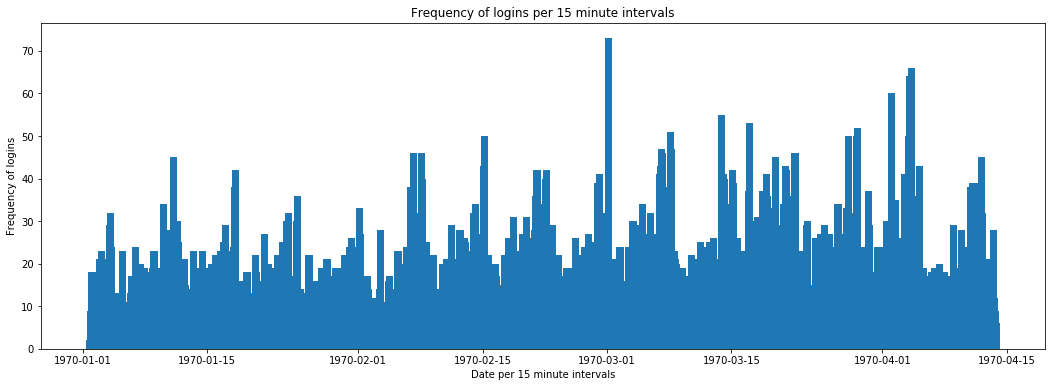

In [11]:
#plotting all data to look for trends
_ = plt.figure(figsize=[18,6])
_ = plt.bar(intervals.index, height=intervals.instance)
_ = plt.xlabel('Date per 15 minute intervals')
_ = plt.ylabel('Frequency of logins')
_ = plt.title('Frequency of logins per 15 minute intervals')
plt.show()

In [12]:
intervals.describe()

,instance
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


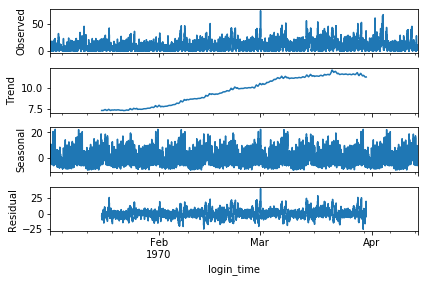

In [13]:
#looking at seasonality of data
'''
freq parameter based on (15days/~2.5 periods * 12hrs/day * 60min/hr * 9.5measures/15min) 
= 2736measures/period 
'''
decomposition = sm.tsa.seasonal_decompose(intervals, model='additive', freq=2736)
fig = decomposition.plot()
plt.show()

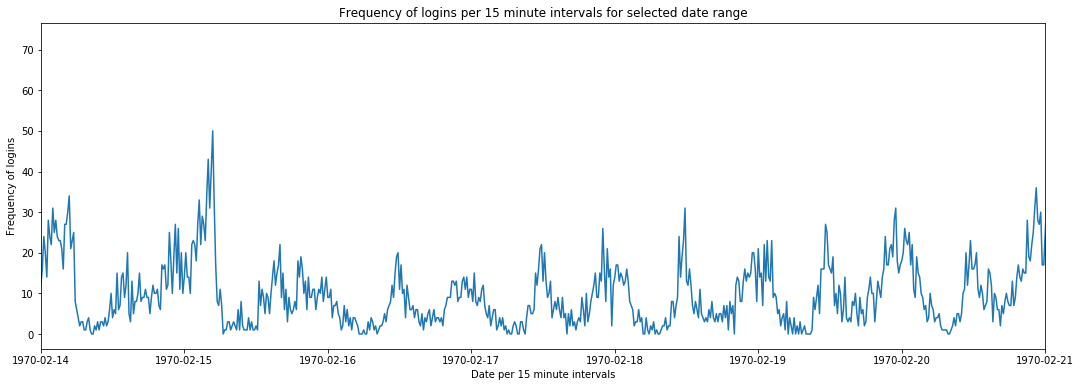

In [14]:
#looking closer at a given date range
min_date = np.datetime64('1970-02-14')
max_date = np.datetime64('1970-02-21')
_ = plt.figure(figsize=[18,6])
_ = plt.plot(intervals.index, intervals.instance)
_ = plt.xlabel('Date per 15 minute intervals')
_ = plt.ylabel('Frequency of logins')
_ = plt.title('Frequency of logins per 15 minute intervals for selected date range')
_ = plt.xlim(min_date, max_date)
plt.show()

In [15]:
#adding day of week and weekday number to dataframe for analysis
intervals = intervals.reset_index()
intervals['Weekday'] = intervals['login_time'].dt.weekday_name

#returns an integer of day of week: Monday=0 to Sunday=6
intervals['WeekdayNum'] = intervals['login_time'].dt.weekday

intervals.head()

,login_time,instance,Weekday,WeekdayNum
0,1970-01-01 20:00:00,2,Thursday,3
1,1970-01-01 20:15:00,6,Thursday,3
2,1970-01-01 20:30:00,9,Thursday,3
3,1970-01-01 20:45:00,7,Thursday,3
4,1970-01-01 21:00:00,1,Thursday,3


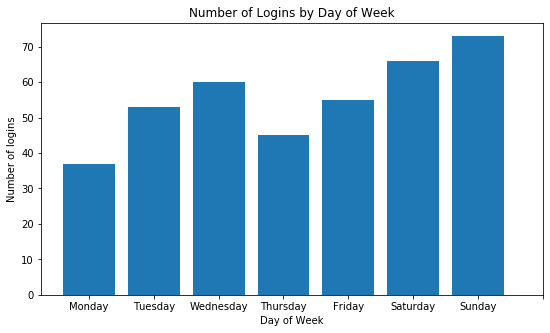

In [16]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_int = [0,1,2,3,4,5,6,7]
_ = plt.figure(figsize=[9,5])
_ = plt.bar(intervals['WeekdayNum'], height=intervals['instance'])
_ = plt.xticks(ticks=weekday_int, labels=days_of_week)
_ = plt.xlabel('Day of Week')
_ = plt.ylabel('Number of logins')
_ = plt.title('Number of Logins by Day of Week')
plt.show()

#### Part 1 conclusion:
There appears to be a cyclical increase in logins every 12 hours or so at around midnight and noon. In general, the trend is rising for logins over the course of the 4.5 months we have data for, with logins at their highest on the weekends and lowest on Mondays and Thursdays. There appears to be an overall trend of logins increasing from Monday-Wednesday, dropping a bit on Thursday, and then increasing through the weekend to begin the pattern again. 

## Part 2: 
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Answer: Weekends seem to be the most obvious answer as this eliminates time of day as a contributing factor/variable. I would look to see if there is a change in driver availability in the opposite city of their primary. 

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    - how you will implement the experiment
    - what statistical test(s) you will conduct to verify the significance of the observation
    - how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Answer: 
- I would implement an A/B test. This allows me to compare the two methods (tolls paid and not) while eliminating any noise from different times/weather conditions/holidays/seasons/etc that may impact driver habits.  

- First, I would select a random group of the total drivers and notify them that their toll fees are being paid for a sample time frame (say, a month). Then I could track in real time whether these drivers habits (example: trips between cities, total trips) are changing at all. I could double check the randomization to the treatment group by running a t-test based on a variable of interest (trips between cities) to compare the two groups. 

- Second, assuming I see a difference in trips between cities between the two groups, I would run a t-test to see if the difference is statistically significant. If that p-value is lower than 0.05, then I would conclude that the treatment (paying the tolls) is *statistically* significant. 

- To be able to provide recommendations, I would look at the minimum detectable effect (MDE). Depending on what degree Ultimate is looking to improve availability (5%? 10%?), the MDE will vary a bit. It would also be worth it to look at how much the reimbursement for tolls is compared to the (assumed) increased revenue from the increased traffic. 
If paying for tolls brings in an acceptable amount of increased revenue and an acceptable increase in availability (likely numbers that will be specific to Ultimate), then I would encourage the change to be made. 

## Part 3:

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday


In [17]:
with open('./ultimate_data_challenge.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [19]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [20]:
df[['signup_date', 'last_trip_date']].head()

,signup_date,last_trip_date
0,2014-01-25,2014-06-17
1,2014-01-29,2014-05-05
2,2014-01-06,2014-01-07
3,2014-01-10,2014-06-29
4,2014-01-27,2014-03-15


In [21]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [22]:
#finding riders who had their last trip within the prior 30 days after 6 months of usage
end = df['signup_date'] + pd.Timedelta('182D')
prior = end - pd.Timedelta('30D')

#mask = (df['last_trip_date'] <= end) & (df['last_trip_date'] > prior)
mask1 = (df['last_trip_date'] > prior) & (df['last_trip_date'] <= end)

df.loc[mask1]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
16,King's Landing,1,2014-01-11,5.0,1.00,2014-06-28,Android,0.0,True,50.0,10.86,3.0
17,King's Landing,0,2014-01-12,3.9,1.00,2014-07-01,iPhone,0.0,True,95.2,2.38,4.8
32,Winterfell,1,2014-01-05,4.0,2.00,2014-06-10,iPhone,100.0,False,100.0,10.01,5.0
36,Astapor,2,2014-01-21,NaN,1.00,2014-06-25,iPhone,0.0,False,50.0,2.43,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...
49973,Astapor,2,2014-01-01,4.0,1.00,2014-06-28,iPhone,0.0,True,25.0,4.07,5.0
49975,Winterfell,11,2014-01-11,3.9,1.03,2014-06-18,iPhone,4.1,False,91.8,2.18,4.8
49976,King's Landing,0,2014-01-21,2.0,1.00,2014-07-01,iPhone,0.0,False,100.0,2.39,4.0
49991,Winterfell,0,2014-01-08,5.0,1.25,2014-06-29,iPhone,100.0,False,0.0,1.06,5.0


We see that the mask is 11194 rows, which represent the riders who were retained. Since the original data was 50000 entries long, 11194/50000 = 0.22 or 22% retention

In [23]:
#creating a mask for non-retained riders
mask0 = (df['last_trip_date'] <= prior)

df.loc[mask0]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [24]:
#adding column to original df to represent retention where 0 = not retained and 1 = retained
df.loc[mask0, 'retained'] = 0

df.loc[mask1, 'retained'] = 1

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
retained                  50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 4.6+ MB


In [25]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

As I look to see which variables have the biggest impact on retention, I would lean to exclude the average rating of driver, since there are 8122 missing values (16%)

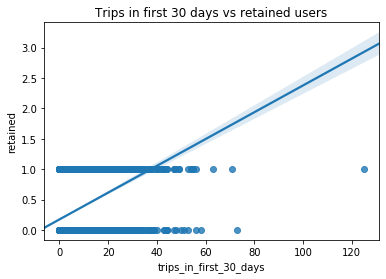

In [26]:
#finding which attribute(s) is/are most predictive of retention
_ = sns.regplot(y='retained', x='trips_in_first_30_days', data=df, fit_reg=True)
_ = plt.title('Trips in first 30 days vs retained users')
plt.show()

In [27]:
#looking for the potential outlier which would be more than 4 trips per day for the first 30 days
df.loc[df['trips_in_first_30_days'] > 100]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8,1.0


<function matplotlib.pyplot.show(*args, **kw)>

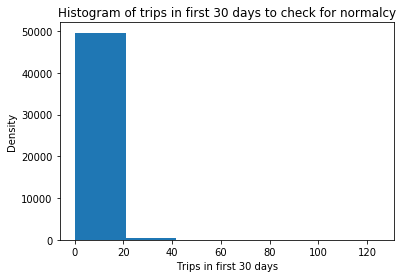

In [28]:
_ = plt.hist(df['trips_in_first_30_days'], bins=6)
_ = plt.title('Histogram of trips in first 30 days to check for normalcy')
_ = plt.xlabel('Trips in first 30 days')
_ = plt.ylabel('Density')
plt.show

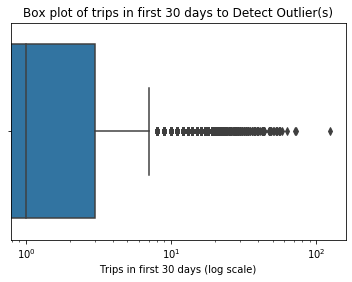

In [29]:
#is King's landing data point (above) an outlier?
f, ax = plt.subplots()
sns.boxplot(x=df['trips_in_first_30_days'])
ax.set_xscale('log')
plt.xlabel('Trips in first 30 days (log scale)')
plt.title('Box plot of trips in first 30 days to Detect Outlier(s)')
plt.show()

It seems to be that not only is the above data point an outlier, a large number of other points are as well. I feel that it is reasonable to remove the single outlier point to not skew the data high, however I will leave the others.

In [30]:
#dropping outlier and ensuring it was dropped
df = df.drop([18514])
df.loc[df['trips_in_first_30_days'] > 100]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained


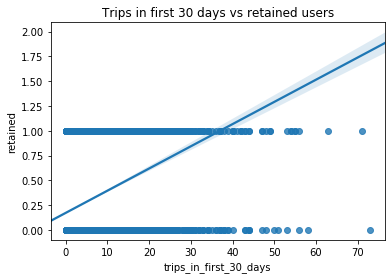

In [31]:
#running this plot again with biggest outlier removed
_ = sns.regplot(y='retained', x='trips_in_first_30_days', data=df, fit_reg=True)
_ = plt.title('Trips in first 30 days vs retained users')
plt.show()

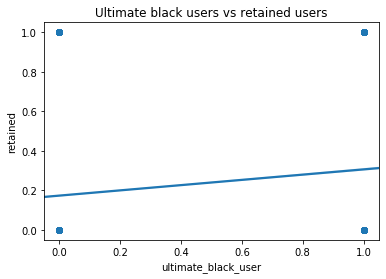

In [32]:
_ = sns.regplot(y='retained', x='ultimate_black_user', data=df, fit_reg=True)
_ = plt.title('Ultimate black users vs retained users')
plt.show()

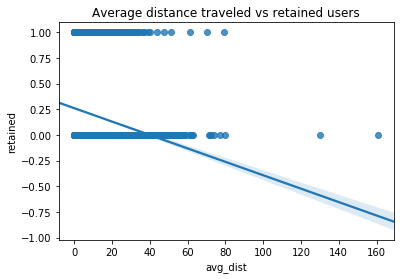

In [33]:
_ = sns.regplot(y='retained', x='avg_dist', data=df, fit_reg=True)
_ = plt.title('Average distance traveled vs retained users')
plt.show()

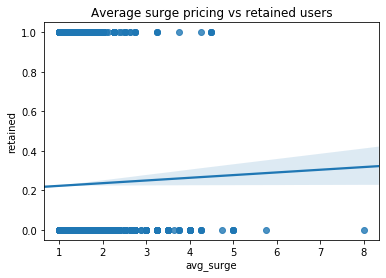

In [34]:
_ = sns.regplot(y='retained', x='avg_surge', data=df, fit_reg=True)
_ = plt.title('Average surge pricing vs retained users')
plt.show()

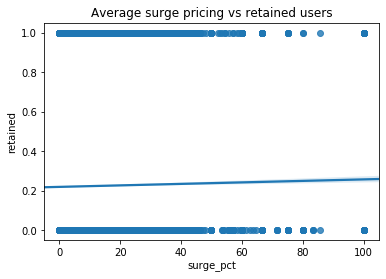

In [35]:
_ = sns.regplot(y='retained', x='surge_pct', data=df, fit_reg=True)
_ = plt.title('Average surge pricing vs retained users')
plt.show()

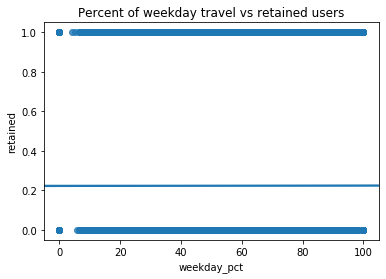

In [36]:
_ = sns.regplot(y='retained', x='weekday_pct', data=df, fit_reg=True)
_ = plt.title('Percent of weekday travel vs retained users')
plt.show()

Observations: retention seems to have a 
 - positive correlation with:
    - number of trips in the first 30 days
    - ultimate black users 
    - average surge multiplier
    - surge percentage
 - negative correlation with: 
     - average distance traveled
 - no obvious trend with:
     - weekday percentage
     
The strongest correlations appear to be with number of trips in the first 30 days and average distance traveled

I debated using logistic regression but decided to go with a random forest because there is not a clear "winner" for prediction and I wanted to better account for the messiness of the features and be able to find relative feature importance

In [37]:
#looking at unique values for categorical variables
print('cities:', df.city.unique())
print('phones:', df.phone.unique())

cities: ["King's Landing" 'Astapor' 'Winterfell']
phones: ['iPhone' 'Android' None]


In [38]:
cities=["King's Landing", 'Astapor', 'Winterfell']
phones=['iPhone', 'Android', 'None']
#assigning dummy/indicator values to convert categorical to integer arrays
dummies1 = pd.get_dummies(df['city'])
dummies2 = pd.get_dummies(df['phone'])

print(dummies1)
print(dummies2)

       Astapor  King's Landing  Winterfell
0            0               1           0
1            1               0           0
2            1               0           0
3            0               1           0
4            0               0           1
...        ...             ...         ...
49995        0               1           0
49996        1               0           0
49997        0               0           1
49998        1               0           0
49999        1               0           0

[49999 rows x 3 columns]
       Android  iPhone
0            0       1
1            1       0
2            0       1
3            0       1
4            1       0
...        ...     ...
49995        0       1
49996        0       1
49997        1       0
49998        0       1
49999        1       0

[49999 rows x 2 columns]


In [39]:
#adding dummy columns to original df
df = pd.concat([df, dummies1, dummies2], axis=1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0.0,0,1,0,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0.0,1,0,0,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.0,1,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1.0,0,1,0,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0.0,0,0,1,1,0


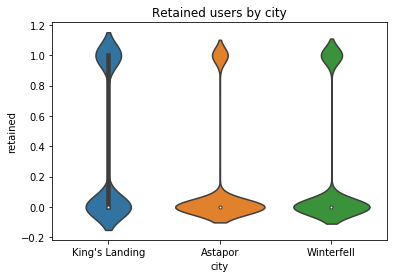

In [40]:
_ = sns.violinplot(y='retained', x="city", data=df)
_ = plt.title("Retained users by city")
plt.show()

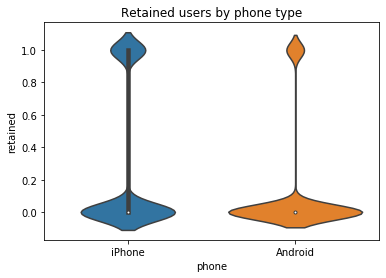

In [41]:
_ = sns.violinplot(y='retained', x='phone', data=df)
_ = plt.title("Retained users by phone type")
plt.show()

In [42]:
#dropping NaN to make random forest easier
df = df.dropna()

In [43]:
#features, excluding signup date and last trip date
X = df[['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', "King's Landing", 'Astapor', 'Winterfell', 'iPhone', 'Android']]
#label
y = df['retained']

#split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [44]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [45]:
#evaluate how well the model did
print('Model accuracy:', metrics.accuracy_score(y_test, y_pred))

Model accuracy: 0.7515683814303639


In [46]:
#looking at feature importance
feature_names = ['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', "King's Landing", 'Astapor', 'Winterfell', 'iPhone', 'Android']
importance = pd.Series(rfc.feature_importances_, index=feature_names).sort_values(ascending=False)
importance

avg_dist                  0.282607
weekday_pct               0.160201
avg_rating_by_driver      0.103199
trips_in_first_30_days    0.094391
avg_rating_of_driver      0.093695
surge_pct                 0.093583
avg_surge                 0.082023
ultimate_black_user       0.022421
King's Landing            0.020719
iPhone                    0.015396
Astapor                   0.012713
Android                   0.010707
Winterfell                0.008346
dtype: float64

Text(0.5, 1.0, 'Visualizing Feature Importance')

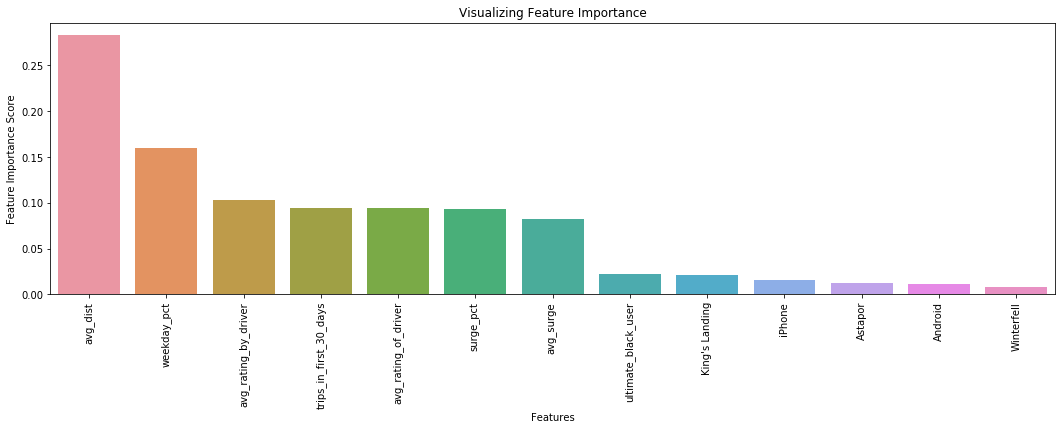

In [47]:
#visualizing feature importance in bar graph
plt.figure(figsize=[18,5])
sns.barplot(x=importance.index, y=importance)
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.title("Visualizing Feature Importance")

In [48]:
#there appears to be a drop off after avg_surge, 
#so I will take the top 7 predictors and run another random forest
X = df[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 
        'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']]
#label
y = df['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

rfc2 = RandomForestClassifier()
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)

In [49]:
print('Accuracy of model after narrowing down to top 7 important features:', metrics.accuracy_score(y_test, y_pred))

Accuracy of model after narrowing down to top 7 important features: 0.7326512884856674


In [50]:
feature_names2 = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 
        'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
importance2 = pd.Series(rfc2.feature_importances_, index=feature_names2).sort_values(ascending=False)
importance2

avg_dist                  0.343327
weekday_pct               0.171432
avg_rating_by_driver      0.115692
trips_in_first_30_days    0.096399
surge_pct                 0.093898
avg_surge                 0.092433
avg_rating_of_driver      0.086820
dtype: float64

Text(0.5, 1.0, 'Visualizing Feature Importance')

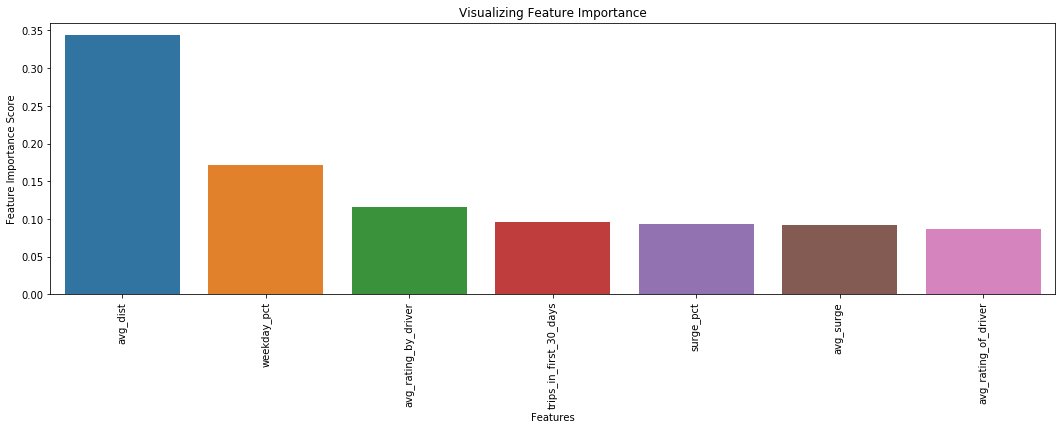

In [51]:
#visualizing feature importance in bar graph
plt.figure(figsize=[18,5])
sns.barplot(x=importance2.index, y=importance2)
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.title("Visualizing Feature Importance")

### Conclusion:
I found that currently, approximately 22% of users are retained. 

To attempt to predict who is retained, I converted the categorical variables of phone type and city to dummy variables to allow them to be used in a random forest classifier and ran this classifier with the other variables. This gave me about 75% accuracy for which riders would be retained after 6 months. 

When I narrowed the model down to the top 7 most important variables, my model accuracy actually decreased, suggesting to me that while phone and city are not the primary reasons a rider may be retained, they still factor in. Overall, the most important feature was the average distance traveled with higher retention seen at lower distances. 

The city that had the best retention was King's Landing, with Astapor having the worst of the three. Perhaps the focus might be on incetivizing shorter distance rides in Astapor to increase long term retention and user-ship. 

Additionally, I notice that Android phone users have worse retention than iPhone users. Perhaps this is a coicindence, but it may be worth looking into the user inferface and see if the app could be improved for Android users. 